### Importing libraries

In [ ]:
# pip install tensorflow
# check out https://www.tensorflow.org/tutorials/images/cnn
# can run and compare results in colab

In [281]:
import os
import pandas as pd
import numpy as np

# import required libaries to process images
import PIL
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline 
 
#using Keras
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [289]:
# follow this on zero padding vs resizing and how it effects accuracy 
# mabye something we talk to Jiaqi about
def pad_images(images, width_max, length_max): 
    padded_images = [] 
    c = 0 
    for image in images: 
        wpad1 = (width_max - image.shape[0])/2
        lpad1 = (length_max - image.shape[1])/2

        if lpad1%1 > 0: 
            lpad1 = int(lpad1)
            lpad2 = int(lpad1)+1
        else: 
            lpad1 = int(lpad1)
            lpad2 = int(lpad1)

        if wpad1%1 > 0: 
            wpad1 = int(wpad1)
            wpad2 = int(wpad1)+1
        else: 
            wpad1 = int(wpad1)
            wpad2 = int(wpad1)
        try:
            padded_images.append(np.pad(image, pad_width=[(wpad1 , wpad2),(lpad1, lpad2),(0, 0)], mode='constant'))
        except: 
            print("at {}".format(c))
        c = c + 1
    return padded_images 

In [290]:
#crop images to center based on full dataset mean_size
def crop_images(images, width_mean, length_mean):
    train_padded_c = []
    for image in images: 
        
        left = int((image.shape[0] - int(width_mean))/2)
        top = int((image.shape[1] - int(length_mean))/2)
        right = int((image.shape[0] + int(width_mean))/2)
        bottom = int((image.shape[1] + int(length_mean))/2)

        train_padded_c.append(image[left:right, top:bottom])
    return train_padded_c

In [291]:
def load_images():

    #get list of images from corsican
    dir = os.getcwd()
    images = os.listdir('{}/assets/wildfire_test_set'.format(dir))
    image_file = [file for file in images if '.DS_Store' not in file]
    fire_image_arrays = [np.asarray(Image.open('{}/assets/wildfire_test_set/{}'.format(dir,image))) for image in image_file]
    fire_label_arrays = []
    for array in fire_image_arrays:
        fire_label_arrays.append([1])

    #get images for fire-less mountains
    images = os.listdir('{}/assets/mountain_test_set'.format(dir))
    image_file = [file for file in images if '.DS_Store' not in file]
    mountain_image_arrays = [np.asarray(Image.open('{}/assets/mountain_test_set/{}'.format(dir,image))) for image in image_file] 
    mountain_label_arrays = []
    for array in mountain_image_arrays:
        mountain_label_arrays.append([0])

    all_image_arrays = fire_image_arrays + mountain_image_arrays
    
    #calculate the mean widths and heights of the images 
    widths = [array.shape[0] for array in all_image_arrays]
    lengths = [array.shape[1] for array in all_image_arrays]
    width_mean = np.mean(widths)
    length_mean = np.mean(lengths)
    width_max = np.max(widths)
    length_max = np.max(lengths)
    
    #pad and crop images 
    all_image_arrays = pad_images(all_image_arrays, width_max, length_max)
    all_image_arrays = crop_images(all_image_arrays, width_mean, length_mean)
    
    all_image_labels = fire_label_arrays + mountain_label_arrays

    data = list(zip(all_image_arrays, all_image_labels))

    return data
data = load_images()

In [292]:
 def test_train_split(data):
    # randomize the images
    import random 
    random.seed(42)
    random.shuffle(data)

    #split into train, test, dev
    data_len = len(data)
    train, dev, test = np.split(data, [int(data_len*.8),int(data_len*.9)])
    train_images, train_labels = zip(*train)
    dev_images, dev_labels = zip(*dev)
    test_images, test_labels = zip(*test)
    
    return train_images, train_labels, dev_images, dev_labels, test_images, test_labels
train_images, train_labels, dev_images, dev_labels, test_images, test_labels = test_train_split(data)

In [293]:
#normalize the images
train_images, dev_images, test_images = np.array(train_images) / 255.0, \
                                        np.array(dev_images) / 255.0, \
                                        np.array(test_images) / 255.0, 

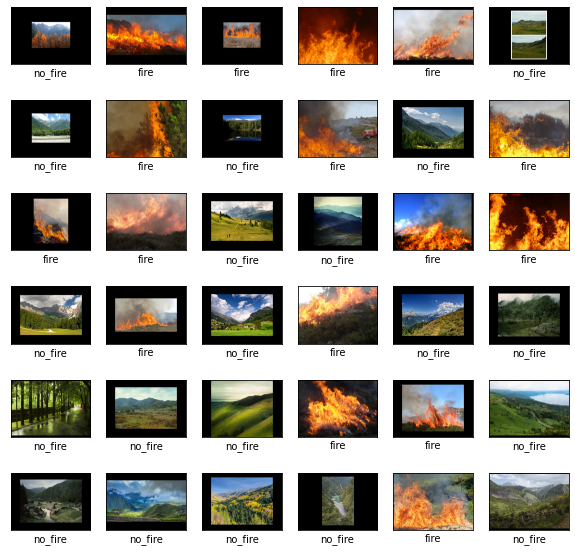

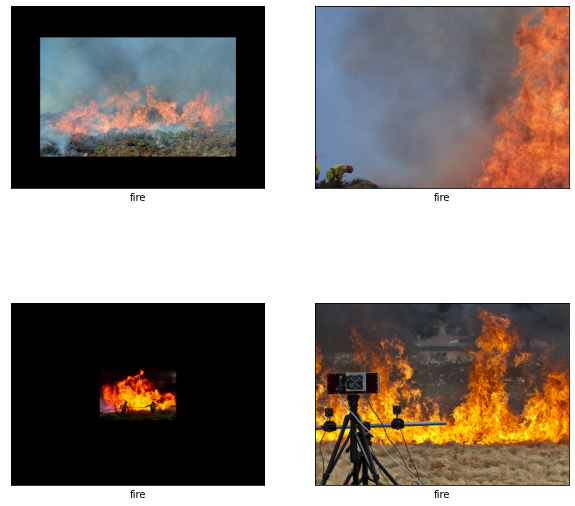

In [295]:
#testing label application
def plot_images(images, labels):
    import math

    p_size = math.floor(math.sqrt(len(images)))

    class_names = ['no_fire','fire']
    plt.figure(figsize=(10,10))
    for i in range(p_size**2):
        plt.subplot(p_size,p_size,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i])
        plt.xlabel(class_names[labels[i][0]])
    
plot_images(train_images, train_labels)
plot_images(test_images, test_labels)

In [314]:
train_images = tf.convert_to_tensor(train_images, dtype=tf.float32)
train_labels = tf.convert_to_tensor(train_labels, dtype=tf.float32)
test_images = tf.convert_to_tensor(test_images, dtype=tf.float32)
test_labels = tf.convert_to_tensor(test_labels, dtype=tf.float32)

In [315]:
train_images[0].shape

TensorShape([952, 1328, 3])

### Importing and examining the images

In [309]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(952, 1328, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))


In [310]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 950, 1326, 32)     896       
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 475, 663, 32)      0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 473, 661, 64)      18496     
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 236, 330, 64)      0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 234, 328, 64)      36928     
Total params: 56,320
Trainable params: 56,320
Non-trainable params: 0
_________________________________________________________________


In [311]:
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10))

In [312]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 950, 1326, 32)     896       
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 475, 663, 32)      0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 473, 661, 64)      18496     
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 236, 330, 64)      0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 234, 328, 64)      36928     
_________________________________________________________________
flatten_4 (Flatten)          (None, 4912128)           0         
_________________________________________________________________
dense_6 (Dense)              (None, 64)               

In [316]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(train_images, train_labels, epochs=10, 
                    validation_data=(test_images, test_labels))

Train on 40 samples, validate on 5 samples
Epoch 1/10
